In [64]:
import sys
sys.path.append('../')
sys.path.append('../data')
sys.path.append('../script')

from src.dataset import Dataset
from src.model import WrapHookedTransformer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variance in the dataset

In [2]:
dataset = Dataset("../data/dataset_gpt2.json")
model = WrapHookedTransformer.from_pretrained("gpt2")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
dataset.print_statistics()
# dataset.filter(filter_value=0.23)
dataset.print_statistics()
dataset.random_sample(100, 16)

----------------------------
Memorizing win number of examples: 9916
Copying win number of examples: 317935
Mean of of memorized token probs in memorizing win: tensor(0.1106)
Mean of of memorized token probs in copying win: tensor(0.0018)
Mean of of orthogonal token probs in copying win: tensor(0.6024)
Mean of of orthogonal token probs in memorizing win: tensor(0.0205)
----------------------------
Memorizing win number of examples: 9916
Copying win number of examples: 317935
Mean of of memorized token probs in memorizing win: tensor(0.1106)
Mean of of memorized token probs in copying win: tensor(0.0018)
Mean of of orthogonal token probs in copying win: tensor(0.6024)
Mean of of orthogonal token probs in memorizing win: tensor(0.0205)
possible_lengths for sampling 100: [12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0]


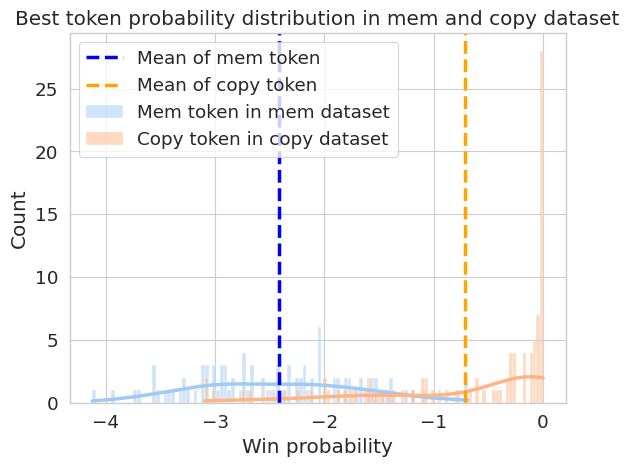

In [93]:
target_win_prob = [math.log(d["target_probs"]) for d in dataset.pos_dataset]
orthogonal_win_prob = [ math.log(d["orthogonal_probs"]) for d in dataset.neg_dataset]

# Plot
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(target_win_prob, bins=100, label="Mem token in mem dataset", kde=True)
sns.histplot(orthogonal_win_prob, bins=100, label="Copy token in copy dataset", kde=True)
#plot mean of target_win_prob
plt.axvline(x=sum(target_win_prob)/len(target_win_prob), color="blue", linestyle="--", label="Mean of mem token")
#plot mean of orthogonal_win_prob
plt.axvline(x=sum(orthogonal_win_prob)/len(orthogonal_win_prob), color="orange", linestyle="--", label="Mean of copy token")
plt.xlabel("Win probability")
plt.ylabel("Count")
plt.legend()
plt.title("Best token probability distribution in mem and copy dataset")
plt.show()

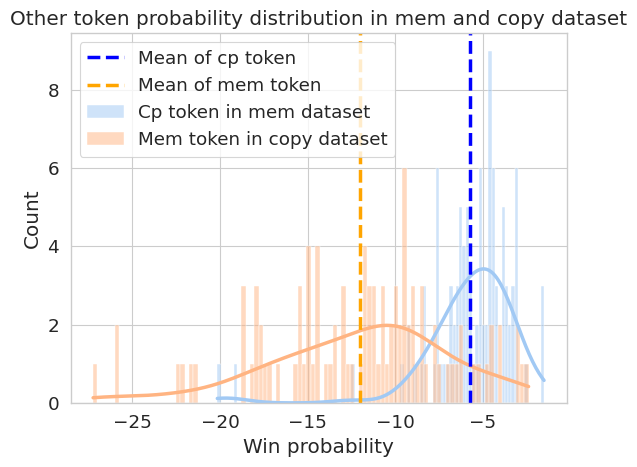

In [94]:

target_win_prob_orthogonal = [ math.log(d["orthogonal_probs"]) for d in dataset.pos_dataset]
orthogonal_win_prob_target = [ math.log(d["target_probs"]) for d in dataset.neg_dataset]

# Plot
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(target_win_prob_orthogonal, bins=100, label="Cp token in mem dataset", kde=True)
sns.histplot(orthogonal_win_prob_target, bins=100, label="Mem token in copy dataset", kde=True)
#plot mean of target_win_prob
plt.axvline(x=sum(target_win_prob_orthogonal)/len(target_win_prob_orthogonal), color="blue", linestyle="--", label="Mean of cp token")
#plot mean of orthogonal_win_prob
plt.axvline(x=sum(orthogonal_win_prob_target)/len(orthogonal_win_prob_target), color="orange", linestyle="--", label="Mean of mem token")
plt.xlabel("Win probability")
plt.ylabel("Count")
plt.legend()
plt.title("Other token probability distribution in mem and copy dataset")
plt.show()

## Variance in the logits

In [7]:
pos_logits = model([d["premise"] for d in dataset.pos_dataset])
neg_logits = model([d["premise"] for d in dataset.neg_dataset])

In [69]:
pos_probs = torch.log_softmax(pos_logits, dim=-1)[:,-1,:]
neg_probs = torch.log_softmax(neg_logits, dim=-1)[:, -1, :]

pos_target_ids = {
    "target": model.to_tokens([d["target"] for d in dataset.pos_dataset], prepend_bos=False),
    "orthogonal": model.to_tokens([d["orthogonal_token"] for d in dataset.pos_dataset], prepend_bos=False),
}
neg_target_ids = {
    "target": model.to_tokens([d["target"] for d in dataset.neg_dataset], prepend_bos=False),
    "orthogonal": model.to_tokens([d["orthogonal_token"] for d in dataset.neg_dataset], prepend_bos=False),
}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


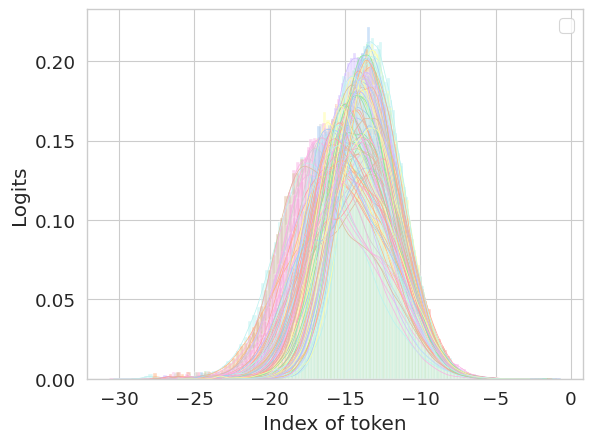

In [66]:
#plot all 100 distribution of logits in the same plot as a line plot
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(pos_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.title("Logits distribution across 100 memorization win cases")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


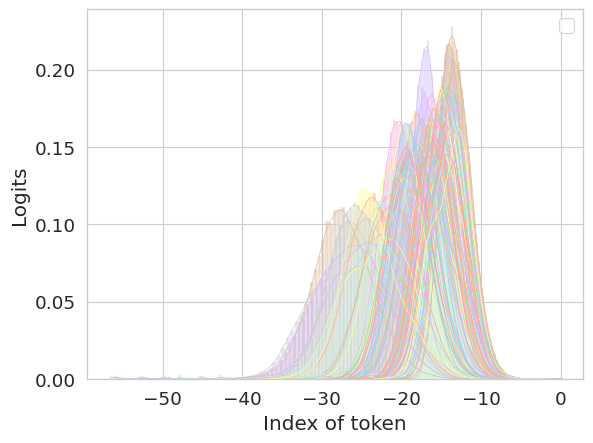

In [67]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(neg_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.title("Logits distribution across 100 copy win cases")
plt.legend()

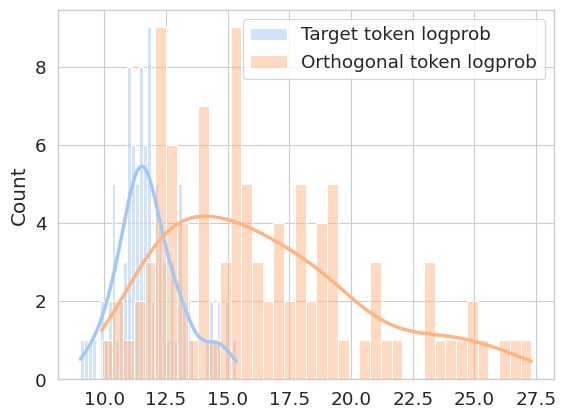

In [88]:
#extract the logprob for the target token and orthogonal token
pos_target_logprob = pos_logits[:,-1,:].gather(-1, index=pos_target_ids["target"]).squeeze(-1)
neg_orthogonal_logprob = neg_logits[:,-1,:].gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)

#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_target_logprob.detach().numpy(), bins=40, label="Target token logprob", kde=True)
sns.histplot(neg_orthogonal_logprob.detach().numpy(), bins=40, label="Orthogonal token logprob", kde=True)
plt.legend()
plt.title("Logprob distribution of best token in mem and copy dataset")
#plot mean of target_win_pro

In [112]:
# add noise
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1, 2, 3, 8, 9, 10, 11],
    target_win=8,
    noise_mlt=1.2
)
neg_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.neg_dataset],
    noise_index=[1, 2, 3, 8, 9, 10, 11],
    target_win=8,
    noise_mlt=1.2
)

pos_corrupted_logit, pos_corrupted_cache = model.run_with_cache_from_embed(pos_input_emb_corrupted)
neg_corrupted_logit, neg_corrupted_cache = model.run_with_cache_from_embed(neg_input_emb_corrupted)

# plot distribution of corrupted logits
pos_corrupted_probs = torch.log_softmax(pos_corrupted_logit, dim=-1)[:,-1,:]
neg_corrupted_probs = torch.log_softmax(neg_corrupted_logit, dim=-1)[:, -1, :]
pos_corrupted_probs_mean = pos_corrupted_probs.mean(dim=-1)
neg_corrupted_probs_mean = neg_corrupted_probs.mean(dim=-1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


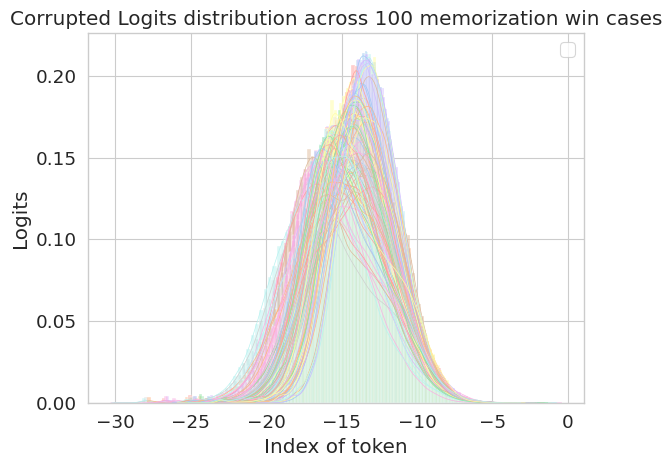

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


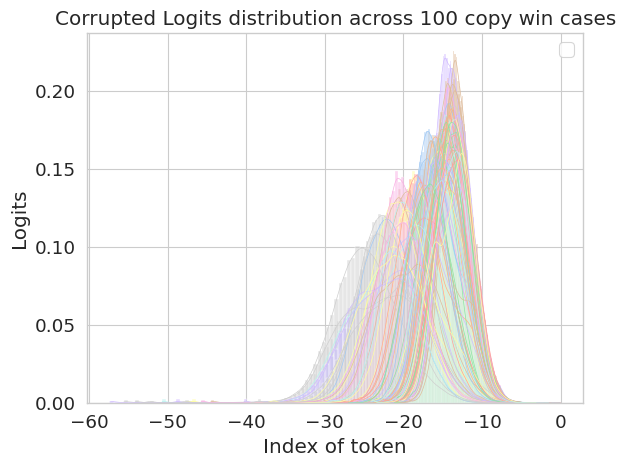

In [114]:


sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(pos_corrupted_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.legend()
plt.title("Corrupted Logits distribution across 100 memorization win cases")
plt.show()

sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(neg_corrupted_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.title("Corrupted Logits distribution across 100 copy win cases")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Corrupted Logprob distribution of best token in mem and copy dataset')

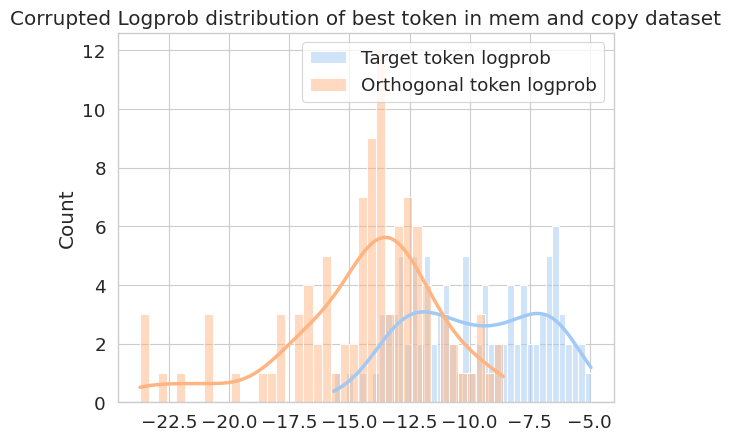

In [97]:
#extract the logprob for the target token and orthogonal token
pos_target_logprob = pos_corrupted_probs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
neg_orthogonal_logprob = neg_corrupted_probs.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)

#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_target_logprob.detach().numpy(), bins=40, label="Target token logprob", kde=True)
sns.histplot(neg_orthogonal_logprob.detach().numpy(), bins=40, label="Orthogonal token logprob", kde=True)
plt.legend()
plt.title("Corrupted Logprob distribution of best token in mem and copy dataset")
#plot mean of target_win_pro

## Variance in the difference

Text(0.5, 1.0, 'Indirect effect of best token in mem and copy dataset over 100 samples')

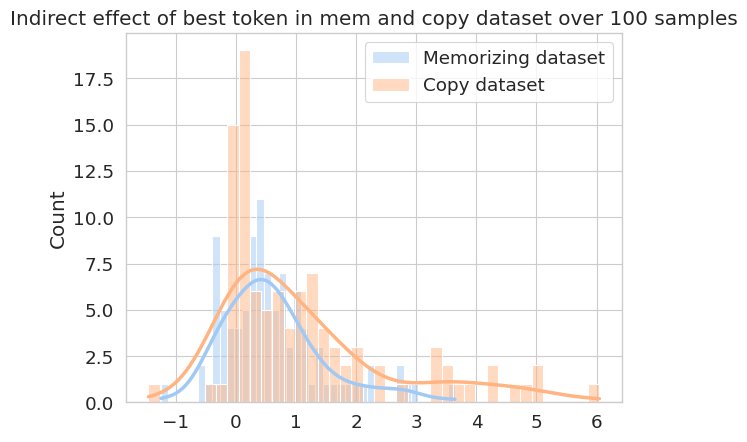

In [113]:
def indirect_effect(logits, corrupted_logits, first_ids_pos, return_type="mean"):
    logits = torch.nn.functional.log_softmax(logits, dim=-1)
    corrupted_logits = torch.nn.functional.log_softmax(corrupted_logits, dim=-1)
    # Use torch.gather to get the desired values
    logits_values = torch.gather(logits[:, -1, :], 1, first_ids_pos).squeeze()
    corrupted_logits_values = torch.gather(corrupted_logits[:, -1, :], 1, first_ids_pos).squeeze()
    
    delta_value = logits_values - corrupted_logits_values

    return delta_value

pos_delta_value = indirect_effect(pos_logits, pos_corrupted_logit, pos_target_ids["target"])
neg_delta_value = indirect_effect(neg_logits, neg_corrupted_logit, neg_target_ids["orthogonal"])
#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_delta_value.detach().numpy(), bins=40, label="Memorizing dataset", kde=True)
sns.histplot(neg_delta_value.detach().numpy(), bins=40, label="Copy dataset", kde=True)
plt.legend()
plt.title("Indirect effect of best token in mem and copy dataset over 100 samples")